In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', size=12)
from thunder.extraction.extraction import SourceExtraction
from thunder.extraction.block.mergers import IgnorePaddingBlockMerger
from thunder.extraction.demixers import Demixer
from thunder.rdds.images import Images
from thunder.rdds.timeseries import TimeSeries
from scipy.ndimage.filters import gaussian_filter
from scipy.io import loadmat
from IPython.core.display import clear_output
from os import system

# Fetch data

In [3]:
data_source = 3

# Fetch Data
if data_source == 1:  # generate 2D model data
    np.random.seed(1)
    T = 30  # duration of the simulation
    sz = (150, 100)  # size of image
    sig = (5, 5)  # neurons size
    foo = 0.1 * np.random.randn(*((T,) + sz))
    bar = np.zeros((T,) + sz)
    N = 15  # number of neurons
    lam = 1
    for i in range(N):
        ind = tuple([np.random.randint(x) for x in sz])
        for j in range(T):
            bar[(j,) + ind] = abs(np.random.randn())
    data = foo + 10 * gaussian_filter(bar, (0,) + sig)
    TargetArea = N * np.prod(2. * np.array(sig)) / np.prod(sz)
    TargetRange = [TargetArea * 0.7, TargetArea * 1.]
    NonNegative = True
    lam = 1
elif data_source == 2:   # Use experimental 2D data
    mat = loadmat('Datasets/data_exp2D')
    data = np.transpose(mat['data'], [2, 0, 1])
    sig = (6, 6)  # estimated neurons size
    N = 40  # estimated number of neurons
    TargetArea = N * np.prod(2. * np.array(sig)) / np.prod(data[0].shape)
    TargetRange = [TargetArea * 0.8, TargetArea * 1.2]
    NonNegative = True
    lam = 1
elif data_source == 3:   # Use experimental 3D data
    mat = loadmat('Datasets/data_exp3D')
    data = np.transpose(mat['data'], [3, 0, 1, 2])
    sig = (2, 2, 2)  # neurons size
    TargetRange = [0.008, 0.015]
    NonNegative = True
    lam = 0.001

In [4]:
dataimg=Images(sc.parallelize(zip(range(len(data)), data)))
blocks0 = dataimg.toBlocks() #(50,50), padding=30)
blocks0.count()

1

# Some function definitions

In [5]:
def iterate(iteration):
    global sources, model, blocks, denoised_data, denoised_centers
    sources = SourceExtraction('grouplasso', merger=merger, 
                               sig=sig, nonNegative=True, verbose=True, 
                            targetAreaRatio=TargetRange, lam=lam).fit(blocks)
    modelB = d.fit(blocks, sources, 'blocks', 
                   removeBackground=True if iteration==0 else False)
    model = d.mergeBlocksToTimeSeries(modelB)
    blocks = d.subtractBackground(blocks0, modelB)
    # get denoised pic
    denoised_data = 0 * data
    ks, vs = model.collectAsArray()
    for ll, k in enumerate(ks):
        for i, c in enumerate(k.coordinates):
            denoised_data[(slice(0,None),)+tuple(c)] = k.values[i]*vs[ll]
    pic_denoised = np.percentile(denoised_data, 99, axis=0)
    pic_res = np.percentile(data-denoised_data, 99, axis=0)
    # plot
    denoised_centers = model.applyKeys(lambda a: a.center).collectKeysAsArray()
    plt.figure(figsize=(12,4))
    plt.suptitle('Iteration '+str(iteration), fontsize=14, y=1)
    plt.subplot(131)
    if data_source==1:
        plt.scatter(*np.where(bar.max(0)>0)[1::-1], s=30,  marker='o', c='white');
    plt.hold(True)
    plt.imshow(pic_data if data_source != 3 else pic_data.max(-1));
    plt.title('Data, centers(Truth)')
    plt.subplot(132)
    plt.scatter(*sources.centers.T[1::-1], s=30,  marker='o', c='white');
    plt.imshow(pic_res if data_source != 3 else pic_res.max(-1));
    plt.title('Residual, centers(GroupLasso)')
    plt.subplot(133)
    plt.scatter(*denoised_centers.T[1::-1], s=30,  marker='o', c='white');
    plt.imshow(pic_denoised if data_source != 3 else pic_denoised.max(-1));
    plt.title('Denoised, centers(NMF)');
    plt.show()

In [6]:
def maxproj(data, title):
    plt.figure(figsize=(12,4))
    plt.suptitle(title, y=1)
    plt.subplot(131)
    plt.scatter(*sources.centers.T[1::-1], s=30,  marker='o', c='white');
    plt.scatter(*denoised_centers.T[1::-1], s=30,  marker='x', c='k');
    plt.imshow(np.percentile(data,99,0).max(-1))
    plt.xlabel('y');plt.ylabel('x');
    plt.subplot(132)
    plt.scatter(*sources.centers.T[2:0:-1], s=30,  marker='o', c='white');
    plt.scatter(*denoised_centers.T[2:0:-1], s=30,  marker='x', c='k');
    plt.imshow(np.percentile(data,99,0).max(0))
    plt.xlabel('z');plt.ylabel('y');
    plt.subplot(133)
    plt.scatter(*sources.centers.T[2::-2], s=30,  marker='o', c='white');
    plt.scatter(*denoised_centers.T[2::-2], s=30,  marker='x', c='k');
    plt.imshow(np.percentile(data,99,0).max(1))
    plt.xlabel('z');plt.ylabel('x');

In [7]:
def video(data, denoised_data, filename=None):
    residual = data - denoised_data 
    mi = np.min(data)
    ma = np.max(data)
    if filename is not None:
        system("mkdir tmp4video")
    for ii in range(data.shape[0]):
        ax = plt.subplot(131)
        plt.gcf().set_size_inches(12,4)
        if data_source==1:
            ax.scatter(*np.where(bar.max(0)>0)[1::-1], s=30, marker='o', c='white')
    #     plt.hold(True)
        ax.imshow(data[ii] if data_source != 3 else data[ii].max(-1),
                  vmin=mi, vmax=ma)
        ax.set_title('Data, centers(Truth)')
        ax2 = plt.subplot(132)
        ax2.scatter(*sources.centers.T[1::-1], 
                    s=30, marker='o', c='white')
        ax2.imshow(residual[ii] if data_source != 3 else residual[
                   ii].max(-1), vmin=mi, vmax=ma)
        ax2.set_title('Residual, centers(GroupLasso)')
        ax3 = plt.subplot(133)
        ax3.scatter(*denoised_centers.T[1::-1], 
                    s=30, marker='o', c='white')
        ax3.imshow(denoised_data[ii] if data_source != 3 else denoised_data[
                   ii].max(-1), vmin=mi, vmax=ma)
        ax3.set_title('Denoised, centers(NMF)')
        if filename is not None:
            plt.savefig('tmp4video/'+str(ii)+'.png')
        clear_output(True)
        plt.show()
    system("convert -delay 10 tmp4video/*.png -quality 100%% \
           -compress None -loop 0 m2v:%s.mp4" %filename)
    system("rm -r tmp4video")

# 1st iteration 

## Run source detection algorithms; Plot results

In [8]:
blocks = blocks0
pic_data = np.percentile(data, 99, axis=0)
merger = None if blocks0.count()==1 else IgnorePaddingBlockMerger()
d = Demixer(sig=sig, verbose=True)

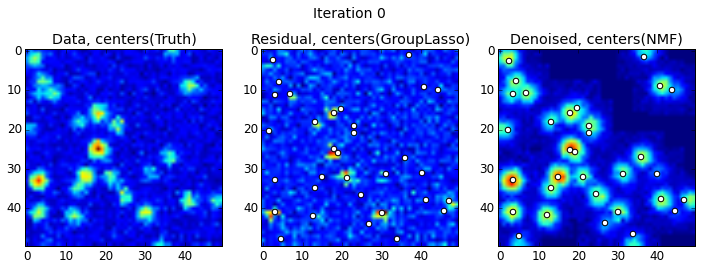

In [9]:
iterate(0)

In [10]:
print (sources.count, len(denoised_centers))

(32, 32)


## Video results 

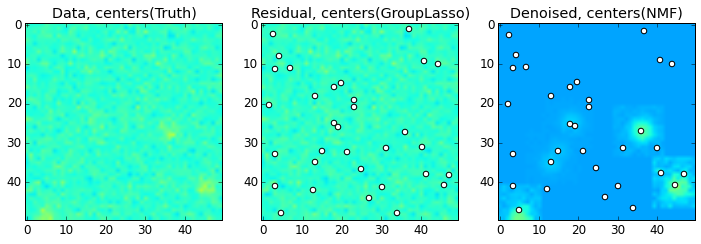

In [11]:
video(data, denoised_data, 'video%g'%data_source)

## Max-Projections

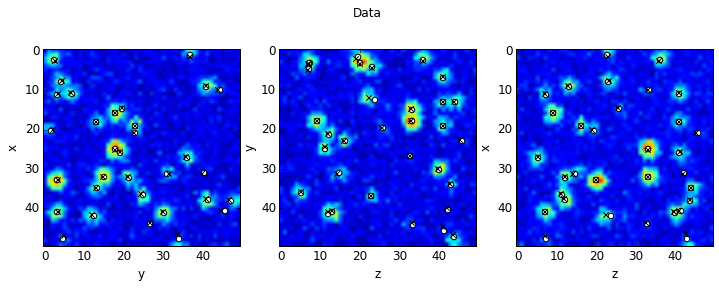

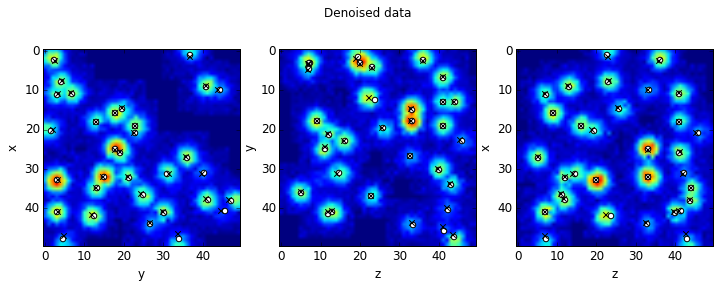

In [12]:
if data_source == 3: 
    maxproj(data, 'Data')
    maxproj(denoised_data, 'Denoised data')

# Further iterations

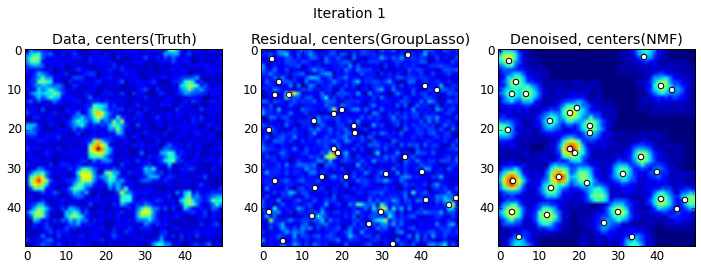

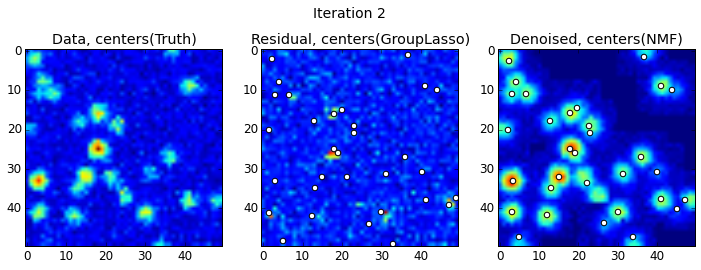

In [13]:
for iteration in range(1,3):
    iterate(iteration)

## Max-Projections

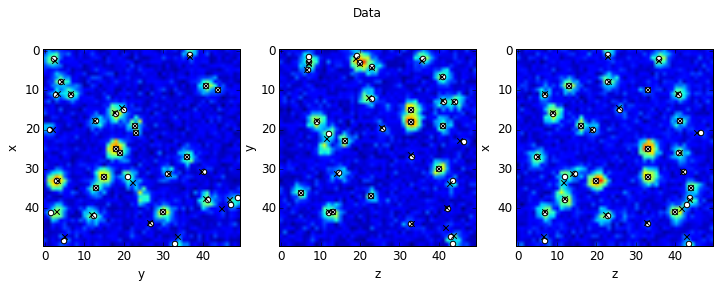

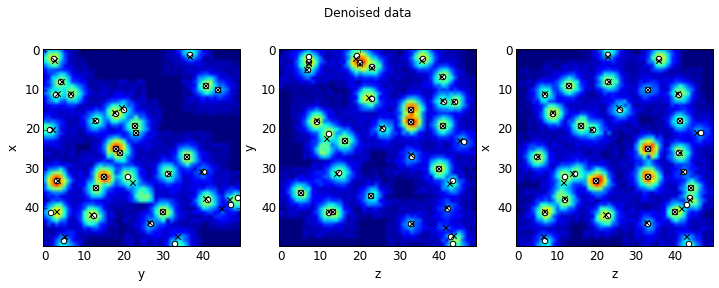

In [14]:
if data_source == 3: 
    maxproj(data, 'Data')
    maxproj(denoised_data, 'Denoised data')